<a href="https://colab.research.google.com/github/mnassar/py2vpy3xai/blob/main/py2v3Malconv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@author: mnassar

This notebook contains the modified malconv architecture and its inherent explainer.

It also contains the code for discovering new patterns.

Modified Malconv Neural Network Architecture

In [ ]:
import tensorflow as tf

In [ ]:
from keras import regularizers
# class fused_lasso_regularizer(regularizers.Regularizer):
#     def __init__(self, fl_coef):
#         self.fl_coef = fl_coef

#     def __call__(self, weight_matrix):
#         minus = tf.math.subtract(weight_matrix[1:WIN_SIZE,:], weight_matrix[:WIN_SIZE-1 ,:])
#         fl = self.fl_coef * tf.math.reduce_mean(tf.math.square(minus))
#         return fl

In [ ]:
import tensorflow as tf

from keras.models import Model
from keras.layers import Dense, Embedding, Conv1D, multiply, GlobalMaxPool1D, Input, Activation


MAX_LEN = 100
WIN_SIZE = 7
NB_FILTERS = 64

def Malconv(max_len=MAX_LEN, win_size=WIN_SIZE, vocab_size=256):
    inp = Input((max_len,))
    emb = Embedding(vocab_size, 8)(inp)
    conv1 = Conv1D(kernel_size=(win_size), filters=NB_FILTERS, strides=(1), padding='same')(emb)
    conv2 = Conv1D(kernel_size=(win_size), filters=NB_FILTERS, strides=(1), padding='same')(emb)
    # conv1 = Conv1D(kernel_size=(win_size), filters=NB_FILTERS, strides=(1), padding='same',
    #                kernel_regularizer=fused_lasso_regularizer(fl_coef=0.1))(emb)
    # conv2 = Conv1D(kernel_size=(win_size), filters=NB_FILTERS, strides=(1), padding='same',
    #                kernel_regularizer=fused_lasso_regularizer(fl_coef=0.1))(emb)
    a = Activation('sigmoid', name='sigmoid')(conv2)
    mul = multiply([conv1, a])
    a = Activation('relu', name='relu', activity_regularizer=regularizers.L1(0.01))(mul) #, activity_regularizer=regularizers.L1(0.01))(mul)
    # a = tf.squeeze(a, axis=2)
    p = GlobalMaxPool1D()(a)
    d = Dense(8)(p)
    out = Dense(1, activation='sigmoid')(d)
    return Model(inp, out)


m = Malconv(win_size=10)
m._name = "m2"
m.summary()

Model: "m2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 8)               2048      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 100, 64)              5184      ['embedding[0][0]']           
                                                                                                  
 conv1d (Conv1D)             (None, 100, 64)              5184      ['embedding[0][0]']           
                                                                                                 

Read and preprocess the data

In [ ]:
# from keras.preprocessing.sequence import pad_sequences
# from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
import numpy as np
import pandas as pd

df = pd.read_csv("dataset80k.csv",
  dtype={
    '__future__': 'object',
    'xrange': 'object'})

df["class"].unique()

array([3, 2])

In [ ]:
# clean NAN lines
df = df.drop ( df[df["lines of code"].isnull()].index )
df[df["lines of code"].isnull()]

,lines of code,class,print(,__future__,xrange,range,"u""",print,unicode(,__next__(,raw_input(,explanation


In [ ]:
x_train = [ bytearray(line, encoding="utf-8") for line in df["lines of code"] ]
y_train = np.array ( df["class"] - 2 )

x_train_padded = pad_sequences(x_train, maxlen=MAX_LEN, padding='post', truncating='post')


In [ ]:
x_train_padded.shape

(81700, 100)

In [ ]:
def data_generator(x_data, y_data, batch_size, shuffle):
    idx = np.arange(len(x_data))
    if shuffle:
        np.random.shuffle(idx)
    nb_batches = len(x_data) // batch_size + 1
    batches = [ idx [ range ( batch_size * i, min(len(x_data), batch_size * (i+1)) ) ]
               for i in range(nb_batches) ]
    while True:
        for i in batches:
            xx = x_data[i]
            yy = y_data[i]
            yield (xx, yy)


In [ ]:
d = data_generator(x_train_padded, y_train, 64, shuffle=True)
next(d)[0].shape

(64, 100)

Training

In [ ]:
import matplotlib.pyplot as plt

Epoch 1/20
5107/5107 [==============================] - 41s 8ms/step - loss: 0.1296 - acc: 0.9648
Epoch 2/20
5107/5107 [==============================] - 39s 8ms/step - loss: 0.0702 - acc: 0.9830
Epoch 3/20
5107/5107 [==============================] - 39s 8ms/step - loss: 0.0599 - acc: 0.9848
Epoch 4/20
5107/5107 [==============================] - 39s 8ms/step - loss: 0.0535 - acc: 0.9863
Epoch 5/20
5107/5107 [==============================] - 43s 8ms/step - loss: 0.0492 - acc: 0.9883
Epoch 6/20
5107/5107 [==============================] - 59s 12ms/step - loss: 0.0458 - acc: 0.9900
Epoch 7/20
5107/5107 [==============================] - 59s 11ms/step - loss: 0.0432 - acc: 0.9906
Epoch 8/20
5107/5107 [==============================] - 50s 10ms/step - loss: 0.0411 - acc: 0.9910
Epoch 9/20
5107/5107 [==============================] - 51s 10ms/step - loss: 0.0398 - acc: 0.9909
Epoch 10/20
5107/5107 [==============================] - 43s 8ms/step - loss: 0.0378 - acc: 0.9913
Epoch 11/20
510

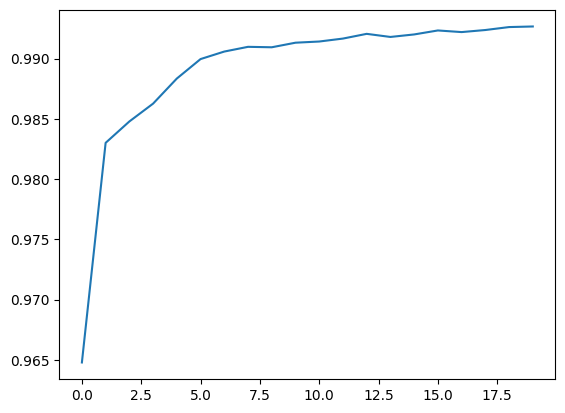

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.losses import BinaryCrossentropy
from os.path import join
import matplotlib.pyplot as plt

BATCH_SIZE = 16
NB_EPOCHS = 20

# bce = BinaryCrossentropy()
# # ear = EarlyStopping(monitor='val_acc', patience=5)
# # mcp = ModelCheckpoint(filepath='malconv.keras')
# def custom_loss(y_true, y_pred):

#   return bce(y_true, y_pred)

m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = m.fit(
    data_generator(x_train_padded, y_train, BATCH_SIZE, shuffle=True),
    steps_per_epoch=len(x_train)//BATCH_SIZE + 1,
    epochs=NB_EPOCHS,
    verbose=1,
    # callbacks=[mcp],
    )

plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])



In [ ]:
m.save("model.keras")

In [ ]:
from keras import models
m = models.load_model('model.keras')
m.summary()


Model: "MM_dataset80k_Win7_NF64"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 100, 8)               2048      ['input_10[0][0]']            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 100, 64)              3648      ['embedding_9[0][0]']         
                                                                                                  
 conv1d_18 (Conv1D)          (None, 100, 64)              3648      ['embedding_9[0][0]']         
                                                                            

Gradient Evaluation

In [ ]:
m.layers

In [ ]:
# gradient playground
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy

bce = BinaryCrossentropy()

def custom_loss(y_true, y_pred):
  return bce(y_true, y_pred)


d = data_generator(x_train_padded, y_train, 1, shuffle=True)
b_t, y_t = next(d)
x_t = tf.cast(b_t, dtype=tf.float32)
with tf.GradientTape() as tape:
  tape.watch(x_t)
  out = m(x_t)
j = tape.gradient(out, x_t)
print(j)

None


Evaluate explainability

In [ ]:
# explanation window (length of extracted explanation)
EXPL_WIN = WIN_SIZE + 3
# explanation successful if longest common substring (contiguous) is greater or equal to expl_eval_thr
EXPL_EVAL_THR = 3

In [ ]:
# we take the values of the filters just before max pooling
# we aggregate by taking the max over the filters' values
intermediate_layer_model = Model(inputs=m.input, outputs=m.get_layer("relu").output)

1/1 [==============================] - 0s 23ms/step
[[0.9984287]] python3
1/1 [==============================] - 0s 24ms/step
(1, 100)


'python3'

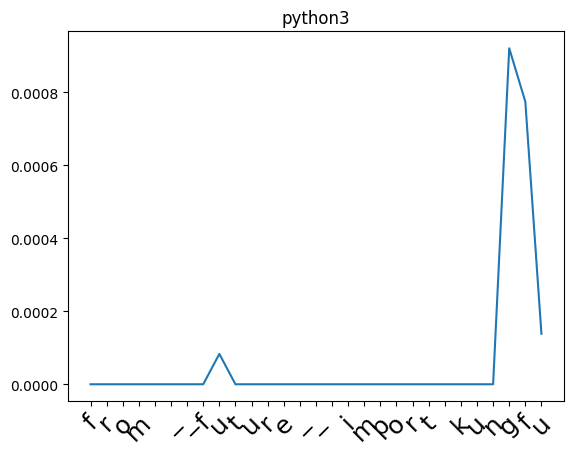

In [ ]:
# sample to explain
line = "from __future__ import kungfu"
sample = [  bytearray(line, encoding="utf-8") ]
sample_padded = pad_sequences(sample, maxlen=MAX_LEN, padding='post', truncating='post')
pred = m.predict(sample_padded)
if pred < 0.5:
  label="python2"
else:
  label="python3"
print (pred, label)

filters = intermediate_layer_model.predict(sample_padded)
max_filter = np.average(filters,axis=2)
print (max_filter.shape)
fig, ax = plt.subplots(1,1)

ax.plot(max_filter[0][:len(line)])
ax.set_title(label)
ax.set_xticks(range(len(line)))
ax.set_xticklabels(list(line), rotation=45, fontsize=18)
label

In [ ]:
# we will try with two approaches:
# - take the max across all filters for each position
# - take the average across all filters for each position
# we take the argmax of the aggregation across all positions as the start index for explaining

samples = [ bytearray(line, encoding="utf-8") for line in df[df["explanation"].notnull()]["lines of code"] ]
# samples
samples_padded = pad_sequences(samples, maxlen=MAX_LEN, padding='post', truncating='post')

filters = intermediate_layer_model.predict(samples_padded)


max_filter = np.max(filters, axis=2)
avg_filter = np.average(filters, axis=2)

print ( max_filter.shape )
print ( avg_filter.shape )

print ( max_filter.argmax(axis=1) )
print ( avg_filter.argmax(axis=1) )


555/555 [==============================] - 3s 6ms/step
(17733, 100)
(17733, 100)
[30 33 36 ...  0 26  8]
[13 33 36 ...  0 26  8]


In [ ]:
# m.predict(samples_padded).reshape(-1)

In [ ]:
df_expl = df[df["explanation"].notnull()]

df_expl = df_expl.join( pd.Series(name="pred", data = m.predict(samples_padded).reshape(-1), index=df_expl.index) )
df_expl = df_expl.join( pd.Series(name="max_max_index", data= max_filter.argmax(axis=1), index=df_expl.index) )
df_expl = df_expl.join( pd.Series(name="max_avg_index", data= avg_filter.argmax(axis=1), index=df_expl.index) )

555/555 [==============================] - 4s 7ms/step


In [ ]:
df_expl.shape


(17733, 15)

In [ ]:
# accuracy for samples with annotated explanations
df_expl["pred_class"] = df_expl["pred"].map(lambda x: 3 if x>0.5 else 2)

acc = sum(df_expl["class"] == df_expl["pred_class"]) * 100 / df_expl.shape[0]
acc

99.71803981277843

In [ ]:
# consider only correct predictions
df_expl = df_expl.loc[df_expl["pred_class"] == df_expl["class"]]
df_expl.shape

(17683, 16)

In [ ]:
def extract_explanation(r, w=EXPL_WIN, col="max_max_index"):
  start_idx  = min(r[col], len(r["lines of code"]) - 1)
  start_idx  = max(start_idx - 2, 0)
  end_idx = min(start_idx + w, len(r["lines of code"]))
  return r["lines of code"][start_idx:end_idx]


df_expl["extracted explanation max"] = df_expl.apply(extract_explanation, col="max_max_index", axis=1)
df_expl["extracted explanation avg"] = df_expl.apply(extract_explanation, col="max_avg_index", axis=1)
df_expl.loc[df_expl["extracted explanation max"]==""]

df_expl



,lines of code,class,print(,__future__,xrange,range,"u""",print,unicode(,__next__(,raw_input(,explanation,pred,max_max_index,max_avg_index,pred_class,extracted explanation max,extracted explanation avg
127,"from __future__ import absolute_import, division",3,NaN,__future__,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__future__,0.991876,33,33,3,"_import, d","_import, d"
229,"setattr(pyparsing_unicode.Japanese, u""カタカナ"", p...",3,NaN,NaN,NaN,NaN,"u""カタカナ"",",NaN,NaN,NaN,NaN,"u""カタカナ"",",0.757865,36,36,3,", u""カタカナ"",",", u""カタカナ"","
1663,"setattr(pyparsing_unicode, u""日本語"", pyparsing_u...",3,NaN,NaN,NaN,NaN,"u""日本語"",",NaN,NaN,NaN,NaN,"u""日本語"",",0.999972,27,27,3,", u""日本語"",",", u""日本語"","
1928,from __future__ import division,3,NaN,__future__,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__future__,0.987167,23,23,3,t division,t division
2005,"console.print(f"" - {sdn}"")",3,"print(f""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"print(f""",0.999410,12,12,3,"int(f"" -","int(f"" -"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81636,for i in range(len(lst)):,3,NaN,NaN,NaN,range(,NaN,NaN,NaN,NaN,NaN,range(,0.999903,11,11,3,range(len(,range(len(
81644,"print (""\nHello, "" + name+ ""\nTime to play han...",3,"print (""\nHello,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"print (""\nHello,",1.000000,3,3,3,"rint (""\nH","rint (""\nH"
81661,"print(""You will be "", desired_age , ""in the ye...",3,"print(""You",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"print(""You",1.000000,0,0,3,"print(""You","print(""You"
81662,"print("" - "" + id.split(""/"")[-1], dark=True)",3,"print(""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"print(""",1.000000,26,26,3,"t(""/"")[-1]","t(""/"")[-1]"


In [ ]:
# evaluating explanations based on RE
# import re
# patterns = {
#         #py3/ print -- 0 or more space -- ( -- 0 or more space -- (1 or more no space)
#         "print(": re.compile(r"\bprint\s*\(\s*\S+"),
#         #py2 (or early versions of py3)/ __future__ -- one or more space
#         "__future__": re.compile(r"\b__future__\s+"),
#         #py2/ xrange -- 0 or more space -- (
#         "xrange": re.compile(r"\bxrange\s*\("),
#         #py3/ space -- range -- 0 or more spaces -- (
#         " range": re.compile(r"\brange\s*\("),
#         #py2/ u (for unicode) -- ' or " -- 0 or more spaces -- 1 or more no spaces
#         'u"': re.compile(r'\bu[\'|\"]\s*\S+'),
#         #print -- 1 or more space -- at least one non-parenthesis -- one or more non space
#         "print ": re.compile(r"\bprint\s+[^\(]+\S+"),
#         #py2/ boundary -- unicode -- (
#         "unicode(": re.compile(r"\bunicode\s*\("),
#         #py3/ space -- __next__ -- space -- (
#         "__next__(": re.compile(r"\b__next__\s*\("),
#         #py2/ raw_input
#         "raw_input(": re.compile(r"\braw_input\s*\(")
#     }

# count_patterns = { k:0 for k in patterns.keys()}

# def eval_expl_2(r, col="extracted explanation max"):
#   for key, pattern in patterns.items():
#     match = re.search(pattern, r[col])
#     if match:
#       count_patterns[key] += 1
#       break

# df_expl.apply(eval_expl_2, col="extracted explanation avg", axis=1)

# count_patterns


In [ ]:
# accuracy
# sum(count_patterns.values()) * 100 / df_expl.shape[0]

In [ ]:
# evaluate explainability
import re
#longest common subsequence
def lcs(X, Y):
    # find the length of the strings
    m = len(X)
    n = len(Y)
    # declaring the array for storing the dp values
    L = [[None]*(n + 1) for i in range(m + 1)]
    """Following steps build L[m + 1][n + 1] in bottom up fashion
    Note: L[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = 0
    return max ( max(l) for l in L )


def eval_expl(r, col="extracted explanation max"):
  # if prediction is wrong, explanation is wrong!
  # not necessarity since it can be the label was incorrect
  # if r["class"] != r["pred_class"]:
  #   return False
  if re.search(re.compile(r'\bu[\'|\"]\s*\S+'), r[col]):
    # print (r[col])
    return True
  return lcs(r["explanation"], r[col]) >= EXPL_EVAL_THR



In [ ]:
df_expl["eval expl max"] = df_expl.apply(eval_expl, col="extracted explanation max", axis=1)
exp_acc_max = sum(df_expl["eval expl max"]) * 100 / df_expl.shape[0]

df_expl["eval expl avg"] = df_expl.apply(eval_expl, col="extracted explanation avg", axis=1)
exp_acc_avg = sum(df_expl["eval expl avg"]) * 100 / df_expl.shape[0]


print (f"{exp_acc_max:.2f}, {exp_acc_avg:.2f}")

98.16, 98.60


In [ ]:
print (m.name)

MM_dataset80k_Win7_NF64


In [ ]:
#breakdown of correct explanations
# print ( df_expl.columns )
# df_expl["print("]
print (" for avg aggregation: ")
for col in ['print(', '__future__', 'xrange', ' range',
       'u"', 'print ', 'unicode(', '__next__(', 'raw_input(']:
  den = df_expl [ df_expl[col].notnull()].shape[0]
  num = df_expl [ df_expl[col].notnull()].loc [ df_expl["eval expl avg"] == True ].shape[0]
  print (col, den, num)

 for avg aggregation: 
print( 958 849
__future__ 6 3
xrange 226 225
 range 234 183
u" 15922 15851
print  816 816
unicode( 266 256
__next__( 3 2
raw_input( 136 133


In [ ]:
print (" for max aggregation: ")
for col in ['print(', '__future__', 'xrange', ' range',
       'u"', 'print ', 'unicode(', '__next__(', 'raw_input(']:
  den = df_expl [ df_expl[col].notnull()].shape[0]
  num = df_expl [ df_expl[col].notnull()].loc [ df_expl["eval expl max"] == True ].shape[0]
  print (col, den, num)

 for max aggregation: 
print( 958 848
__future__ 6 3
xrange 226 224
 range 234 188
u" 15922 15769
print  816 816
unicode( 266 254
__next__( 3 2
raw_input( 136 132


In [ ]:
# What is the issue with a given pattern's explanations ?
t_df = df_expl[df_expl['u"'].notnull()].loc[df_expl["eval expl max"] == False]
t_df = t_df [["lines of code","explanation","extracted explanation max"]]

for i in range(len(t_df)):
  print (t_df.iloc[i,0])
  print ("explanation: *" + t_df.iloc[i,1] +  "*")
  print ("extracted: *" +  t_df.iloc[i,2] + "*")
  print("---")




What is wrong with the explainer?

In [ ]:
nb_wrong_expl = df_expl[df_expl["eval expl avg"]==False].shape[0]
nb_wrong_expl_py2 = df_expl[df_expl["eval expl avg"]==False][df_expl["class"]==2].shape[0]
nb_wrong_expl_py3 = df_expl[df_expl["eval expl avg"]==False][df_expl["class"]==3].shape[0]

print ( nb_wrong_expl_py2, nb_wrong_expl_py3)
"py2:{:.2f}% py3:{:.2f}%".format(nb_wrong_expl_py2*100/nb_wrong_expl,  nb_wrong_expl_py3*100/nb_wrong_expl)

63 184


<ipython-input-31-0aa4f472e082>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nb_wrong_expl_py2 = df_expl[df_expl["eval expl avg"]==False][df_expl["class"]==2].shape[0]
<ipython-input-31-0aa4f472e082>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nb_wrong_expl_py3 = df_expl[df_expl["eval expl avg"]==False][df_expl["class"]==3].shape[0]


'py2:25.51% py3:74.49%'

In [ ]:
nb_wrong_expl = df_expl[df_expl["eval expl max"]==False].shape[0]
nb_wrong_expl_py2 = df_expl[df_expl["eval expl max"]==False][df_expl["class"]==2].shape[0]
nb_wrong_expl_py3 = df_expl[df_expl["eval expl max"]==False][df_expl["class"]==3].shape[0]
print ( nb_wrong_expl_py2, nb_wrong_expl_py3, nb_wrong_expl)
"py2:{:.2f}% py3:{:.2f}%".format(nb_wrong_expl_py2*100/nb_wrong_expl,  nb_wrong_expl_py3*100/nb_wrong_expl)

130 196 326


<ipython-input-32-a272ff280592>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nb_wrong_expl_py2 = df_expl[df_expl["eval expl max"]==False][df_expl["class"]==2].shape[0]
<ipython-input-32-a272ff280592>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nb_wrong_expl_py3 = df_expl[df_expl["eval expl max"]==False][df_expl["class"]==3].shape[0]


'py2:39.88% py3:60.12%'

In [ ]:
# analysis for avg
t_df = df_expl[df_expl["eval expl avg"]==False][df_expl["class"]==2][["lines of code","explanation","extracted explanation avg"]]
for i in range(len(t_df)):
  print (t_df.iloc[i,0])
  print (t_df.iloc[i,1])
  print (t_df.iloc[i,2])
  print("---")
  # print(r)
  # print(j)

In [ ]:
#analysis for max
t_df = df_expl[df_expl["eval expl max"]==False][df_expl["class"]==2][["lines of code","explanation","extracted explanation max"]]
for i in range(len(t_df)):
  print (t_df.iloc[i,0])
  print (t_df.iloc[i,1])
  print (t_df.iloc[i,2])
  print("---")


Discover new patterns


In [ ]:
# all samples having no annotated explanation
samples = [ bytearray(line, encoding="utf-8") for line in df[df["explanation"].isnull()]["lines of code"] ]
samples_padded = pad_sequences(samples, maxlen=MAX_LEN, padding='post', truncating='post')

filters = intermediate_layer_model.predict(samples_padded)

max_filter = np.max(filters, axis=2)
avg_filter = np.average(filters, axis=2)

print ( max_filter.shape )
print ( avg_filter.shape )

print ( max_filter.argmax(axis=1) )
print ( avg_filter.argmax(axis=1) )

1999/1999 [==============================] - 12s 6ms/step
(63967, 100)
(63967, 100)
[ 4 25  7 ... 16 55 14]
[ 4 25  7 ... 16 55 14]


In [ ]:
# filter for loc with no explanation
t_df = df[df["explanation"].isnull()]
t_df = t_df.join( pd.Series(name="pred", data = m.predict(samples_padded).reshape(-1), index=t_df.index) )
t_df = t_df.join( pd.Series(name="max_max_index", data= max_filter.argmax(axis=1), index=t_df.index) )
t_df = t_df.join( pd.Series(name="max_avg_index", data= avg_filter.argmax(axis=1), index=t_df.index) )
t_df["pred_class"] = t_df["pred"].map(lambda x: 3 if x>0.5 else 2)

1999/1999 [==============================] - 16s 8ms/step


In [ ]:

t_df["extracted explanation max"] = t_df.apply(extract_explanation, col="max_max_index", axis=1)
t_df["extracted explanation avg"] = t_df.apply(extract_explanation, col="max_avg_index", axis=1)
# t_df[t_df["extracted explanation max"]==""]

t_df

,lines of code,class,print(,__future__,xrange,range,"u""",print,unicode(,__next__(,raw_input(,explanation,pred,max_max_index,max_avg_index,pred_class,extracted explanation max,extracted explanation avg
0,"extra_ok_returncodes=extra_ok_returncodes,",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996032,4,4,3,tra_ok_ret,tra_ok_ret
1,"from .base import Candidate, Requirement",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,25,25,3,"date, Requ","date, Requ"
2,import zipfile,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999787,7,7,3,t zipfile,t zipfile
3,class DistutilsSetupError (DistutilsError):,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995634,40,40,3,ror):,ror):
4,"original = original or getattr(_os, name)",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999847,0,0,3,original =,original =
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81696,"def infixNotation(baseExpr, opList, lpar=Suppr...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,17,50,3,on(baseExp,"s('('), rp"
81697,def __init__( self ):,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999900,17,17,3,elf ):,elf ):
81698,"""base installation directory for platform-spec...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,16,16,3,tion direc,tion direc
81699,"assert value in (1, -1), ""allowed polarity_lef...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999385,55,55,3,s are: -1,s are: -1


In [ ]:
# for py3

t_df2 = t_df[["lines of code","explanation","class","pred_class","extracted explanation avg","extracted explanation max"]]

print ( t_df2.shape )

# input()

# for i in range(100):
#   print (t_df2.iloc[i,0])
#   print (t_df2.iloc[i,2])
#   print("---")

(63967, 6)


Discovering New Patterns -- a better strategy

for each of the following patterns:
- compute the support of the pattern in the dataset
- explain and check it makes sense


In [ ]:
def extract_explanation_line(line, idx, w=EXPL_WIN):
  start_idx  = min(idx, len(line) - 1)
  start_idx  = max(start_idx - 2, 0)
  end_idx = min(start_idx + w, len(line))
  return line[start_idx:end_idx]

In [ ]:
# loc_py = re.compile(r"\.bit_length\(\)")
# loc_py = re.compile(r"\(len\(bin\(.*\)")
# loc_py = re.compile(r"^@.*")
# loc_py = re.compile(r"def __nonzero__")
# loc_py = re.compile(r"bytes\(.*\)")
# loc_py = re.compile(r"str\(.*\)")
# loc_py = re.compile(r"from collections")

In [ ]:
loc_py = re.compile(r"\.bit_length\(\)")
# loc_py = re.compile(r"^@.*")
# loc_py = re.compile(r"from collections .*")
# loc_py = re.compile(r"dict((.*, .*) for (.*, .*) in .*)")
# loc_py = r"except .* as .*"
# loc_py = r"except .*, .*"
# loc_py = r"f'.* {.*}'"

def discover(r):
  global count_py3, count_py2
  match = re.search(loc_py, r["lines of code"])
  if match and r["class"] == 3:

    print (r["lines of code"])
    print ( match.group() )
    print (r["explanation"])
    print (r["extracted explanation avg"])
    print (r["extracted explanation max"])
    if r["class"] == 2:
      count_py3 += 1
    else:
      count_py2 += 1

    print (r["class"])
    print (r["pred_class"])
    print ("======")
    # input()

count_py3 = 0
count_py2 = 0

t_df2.apply(discover, axis=1)
print ("support = ", count_py3, count_py2)



return i.bit_length()
.bit_length()
nan
return i.b
return i.b
3
3
support =  0 1


In [ ]:
# test fixes

# line = "dict((key, val) for (key, val) in tuple_of_stuff)"
# line = "except (RuntimeError, ImportError) as .*"
line = "f'test: {a}'"

sample = [  bytearray(line, encoding="utf-8") ]
sample_padded = pad_sequences(sample, maxlen=MAX_LEN, padding='post', truncating='post')
pred = m.predict(sample_padded)
if pred < 0.5:
  label="python2"
else:
  label="python3"
print (pred, label)

filters = intermediate_layer_model.predict(sample_padded)
max_filter = np.average(filters,axis=2)
idx = max_filter.argmax(axis=1)[0]
# print(idx)
print (extract_explanation_line(line, idx))



1/1 [==============================] - 0s 37ms/step
[[0.9245385]] python3
1/1 [==============================] - 0s 39ms/step
f'test: {a


In [ ]:
# test fixes

# line = "def foo() -> 'bar': pass"
# line = "def foo(): pass"

# line = "a = something.bit_length()"
# line = "a = (len(bin(something)) - 2)"

# line = "def __bool__(self):"
# line = "def __nonzero__(self):"

# line = "bytes(x)"
# line = "str(x)"

# line = "from collections import UserDict"
# line = "from UserDict import UserDict"